In [15]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import unary_union
from shapely import wkt
import folium
from PIL import Image, UnidentifiedImageError
import osmnx as ox
from IPython.display import display
import os
import sys
sys.path.append(os.path.abspath(".."))
from src.helper_funcs import segmentation

In this Notenook:
1) segmentation: calculate the percentage of pixels that are labeled as 'vegetation'
2) enrich data: take into accoung bike lane data
3) data analytics: some exploratory analysis of the green view data in Berlin

1. segmentation: calculate the percentage of pixels that are labeled as 'vegetation'

In [16]:
def load_image(filename):
    file_path = os.path.join(image_dir, filename)
    if os.path.exists(file_path):
        try:
            return Image.open(file_path)
        except UnidentifiedImageError:
            print(f"Warning: Unidentifiable image file {file_path}")
            return None 
    else:
        return None  

In [17]:
df = pd.read_csv('../data/image_metadata_xx.csv')
image_dir = '../data/images_xx'

In [18]:
df["image"] = df["filename"].apply(load_image)

In [19]:
df['green_view'] = segmentation(df.image, 'vegetation')

In [20]:
df.head(3)

,filename,date,lat,lon,geometry,street_name,image,green_view
0,image_0.jpg,2022-09-01,52.526519,13.447737,"LINESTRING (13.4477389 52.526513, 13.4476831 5...",Danziger Straße,<PIL.JpegImagePlugin.JpegImageFile image mode=...,7.032500
1,image_1.jpg,2022-08-01,52.527085,13.446722,"LINESTRING (13.4441546 52.5294469, 13.444285 5...",Danziger Straße,<PIL.JpegImagePlugin.JpegImageFile image mode=...,23.620625
2,image_2.jpg,2022-08-01,52.537557,13.428725,"LINESTRING (13.4287152 52.5375413, 13.4287918 ...",Winsstraße,<PIL.JpegImagePlugin.JpegImageFile image mode=...,12.325625


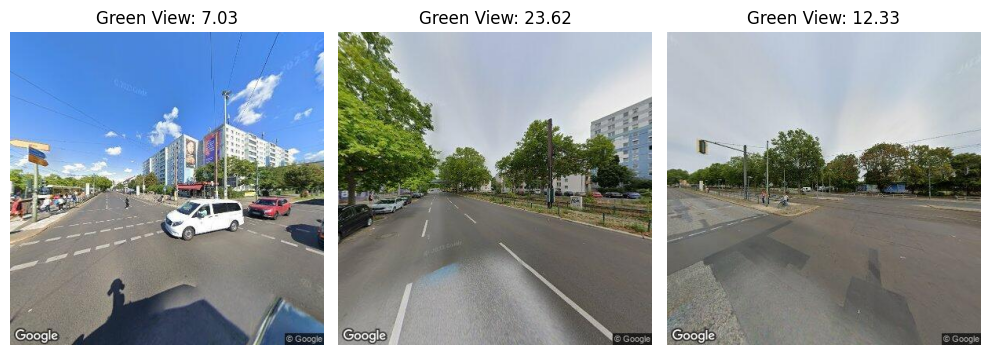

In [21]:
fig, axes = plt.subplots(1, len(df), figsize=(10, 5))

for ax, (_, row) in zip(axes, df.iterrows()):
    # Display the image
    ax.imshow(row['image'])
    ax.axis('off')  # Turn off axis
    ax.set_title(f"Green View: {row['green_view']:.2f}")

plt.tight_layout()
plt.show()

2) enrich data: take into accoung bike lane data

In [22]:
# https://gdi.berlin.de/geonetwork/srv/ger/catalog.search#/metadata/0c37901e-f16f-3c4d-aa0b-10e1bde35af2
bike_df =gpd.read_file('../data/bike_network.json')

In [23]:
bike_df.set_index('gisid', inplace=True)

In [31]:
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geometry')

In [32]:
#set buffer for sjoin --> merge bike lane data with gvi
df['buffer'] = df['geometry'].buffer(distance=0.0001)

In [ ]:
"""m = folium.Map(location=[df.geometry.centroid.y.mean(), df.geometry.centroid.x.mean()], zoom_start=10)

for _, row in df.iterrows():
    folium.GeoJson(row['buffer'].__geo_interface__).add_to(m)
    
for _, row in bike_df.iterrows():
    folium.GeoJson(row['geometry'].__geo_interface__, style_function=lambda x: {'color': 'green'}).add_to(m)

m"""

In [37]:
df_bikelanes = gpd.sjoin(df, bike_df, how='left',predicate = "intersects" )

/tmp/ipykernel_44817/251193326.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df_bikelanes = gpd.sjoin(df, bike_df, how='left',predicate = "intersects" )


In [38]:
# for droping duplicates
df_bikelanes.drop(['elem_nr', 'index_right', 'image'], inplace=True, axis=1)

In [40]:
#multiple edge lane starts intersect with a single bikelane 
df_bikelanes.drop_duplicates(keep='first', inplace=True)

In [41]:
df_bikelanes

,filename,date,lat,lon,geometry,street_name,green_view,buffer,ist_radvorrangnetz,existenz
0,image_0.jpg,2022-09-01,52.526519,13.447737,"LINESTRING (13.44774 52.52651, 13.44768 52.526...",Danziger Straße,7.032500,"POLYGON ((13.44761 52.52649, 13.44757 52.52653...",NaN,NaN
1,image_1.jpg,2022-08-01,52.527085,13.446722,"LINESTRING (13.44415 52.52945, 13.44429 52.529...",Danziger Straße,23.620625,"POLYGON ((13.44435 52.52942, 13.44450 52.52930...",NaN,NaN
2,image_2.jpg,2022-08-01,52.537557,13.428725,"LINESTRING (13.42872 52.53754, 13.42879 52.537...",Winsstraße,12.325625,"POLYGON ((13.42872 52.53769, 13.42872 52.53769...",Ergänzungsnetz,"ja, in Straßennetz"


3. data analytics: some exploratory analysis of the green view data in Berlin

In [47]:
df_bikelanes[df_bikelanes['existenz'] != 'ja, in Straßennetz']

,filename,date,lat,lon,geometry,street_name,green_view,buffer,ist_radvorrangnetz,existenz
0,image_0.jpg,2022-09-01,52.526519,13.447737,"LINESTRING (13.44774 52.52651, 13.44768 52.526...",Danziger Straße,7.032500,"POLYGON ((13.44761 52.52649, 13.44757 52.52653...",NaN,NaN
1,image_1.jpg,2022-08-01,52.527085,13.446722,"LINESTRING (13.44415 52.52945, 13.44429 52.529...",Danziger Straße,23.620625,"POLYGON ((13.44435 52.52942, 13.44450 52.52930...",NaN,NaN


In [ ]:
top10 = result

In [ ]:
top10 = top10[top10['existenz'] != 'ja, in Straßennetz']

In [ ]:
top10 = top10.groupby('edge_name').agg({'green_view': 'mean', 'length':'sum', 'ratio':'mean'}).reset_index()

In [ ]:
# get a certain length for a more represantive bike activity
#top10 = top10[top10['length']>10]

In [ ]:
top10.nsmallest(10, 'ratio')